In [1]:
from astropy.cosmology import FlatLambdaCDM
from astropy.units import Quantity
from slsim.lens_pop import LensPop
import numpy as np
from slsim.image_simulation import lens_image_series
from slsim.Plots.plot_functions import create_image_montage_from_image_list
from slsim.image_simulation import point_source_coordinate_properties
from slsim import lsst_science_pipeline
import matplotlib.pyplot as plt
import corner
import astropy.coordinates as coord
import astropy.units as u
import time

## Supernovae plus extended source simulation using OpSim
In this notebook, we simulate population of lensed supernovae and simulate image of a 

random lensed supernovae. It follows following steps:

1. Simulate lensed supernovae population
2. Choose a lens at random
3. Set observation time and other image configuration
4. Simulate image of a selected lens
5. Visualize it

Before running this notebook, please download the "scotch_SNIa_host_galaxies.fits"

file from the following link: https://github.com/LSST-strong-lensing/data_public.git. 

This file contains type Ia supernovae host galaxies.

## Simulate lens and source galaxy populations

In [2]:
# define a cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)


# define a sky area
area = 1
sky_area = Quantity(value=area, unit="deg2")

start_time = time.time()
# define limits in the intrinsic deflector and source population (in addition to the
# skypy config
# file)
kwargs_deflector_cut = {"z_min": 0.01, "z_max": 2.5}
kwargs_source_cut = {}
## create a point plus extended source lens population.
supernova_lens_pop = LensPop(
    deflector_type="all-galaxies",  # type of the deflector. It could be elliptical or
    # all-galaxies.
    source_type="supernovae_plus_galaxies",  # keyword for source type. it can be
    # galaxies, quasar, quasar_plus_galaxies, and supernovae_plus_galaxies.
    kwargs_deflector_cut=kwargs_deflector_cut,  # cuts that one wants to apply for the
    # deflector.
    kwargs_source_cut=kwargs_source_cut,  # cuts that one wants to apply for the
    # source.
    variability_model="light_curve",  # keyword for the variability model.
    kwargs_variability={"supernovae_lightcurve", "i"},  # specify kewords for
    # lightcurve. "i" is a band for the lightcurve.
    sn_type="Ia",  # supernovae type.
    sn_absolute_mag_band="bessellb",  # Band used to normalize to absolute magnitude
    sn_absolute_zpsys="ab",  # magnitude system. It can be Optional, AB or Vega.
    kwargs_mass2light=None,  # mass-to-light relation for the deflector galaxy.
    skypy_config=None,  # Sky configuration for the simulation. If None, lsst-like
    # configuration will be used.
    sky_area=sky_area,  # Sky area for the simulation, source / deflector sky area
    cosmo=cosmo,  # astropy cosmology
    source_light_profile="single_sersic",  # light profile for the source galaxy
    catalog_type=None,  # catalog type. It can be None or scotch
    lightcurve_time=np.linspace(-50, 100, 1000),  # array of light curve observation time.
    #catalog_path="../data/Scotch/"
    #+ "scotch_SNIa_host_galaxies.fits",
    # path for catalog. If not provided, small size catalog from
    # /slsim/Source/SupernovaeCatalog will be used for
    # source_type="supernovae_plus_galaxies" case. For other cases, we do not need to
    # provide outside catalog. One can download scotch_SNIa_host_galaxies.fits from
    # https://github.com/LSST-strong-lensing/data_public.git
)
end_time = time.time()
print(np.around((end_time - start_time)/60,2), 'minutes needed to simulate ', area, 'square degrees.')

/Users/nikki/Documents/Research/Projects/slsim/slsim/Sources/Supernovae/supernovae_pop.py:95: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  numerator = integrate.quad(
/Users/nikki/Documents/Research/Projects/slsim/slsim/Sources/Supernovae/supernovae_pop.py:95: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  numerator = integrate.quad(
/Users/nikki/Documents/Research/Projects/slsim/slsim/Sources/Supernovae/supernovae_pop.py:95: IntegrationWarning: The integral is

3.37 minutes needed to simulate  1 square degrees.


In [3]:
print("Found", supernova_lens_pop.deflector_number, "potential lenses and",
      supernova_lens_pop.source_number, "potential sources.")



Found 1204203 potential lenses and 2678 potential sources.


## Generate strong lensing systems

In [4]:
start_time = time.time()
# specifying cuts of the population
kwargs_lens_cuts = {}
# drawing population
supernovae_lens_population = supernova_lens_pop.draw_population(
    kwargs_lens_cuts=kwargs_lens_cuts
)

end_time = time.time()
print(
    np.around((end_time - start_time) / 60, 2),
    "minutes needed to generate strong lenses.",
)
print("Number of strong lens systems:", len(supernovae_lens_population))

2.77 minutes needed to generate strong lenses.
Number of strong lens systems: 7


In [5]:
lens_samples = []
labels = [
    r"$\sigma_v$",
    r"$\log(M_{*})$",
    r"$\theta_E$",
    r"$z_{\rm l}$",
    r"$z_{\rm s}$",
    r"$m_{\rm host}$",
    r"$m_{\rm ps}$",
    r"$m_{\rm lens}$",
]

for supernovae_lens in supernovae_lens_population:
    vel_disp = supernovae_lens.deflector_velocity_dispersion()
    m_star = supernovae_lens.deflector_stellar_mass()
    theta_e = supernovae_lens.einstein_radius
    zl = supernovae_lens.deflector_redshift
    zs = supernovae_lens.source_redshift
    source_mag = supernovae_lens.extended_source_magnitude(band="i", lensed=True)
    ps_source_mag = supernovae_lens.point_source_magnitude(band="i")
    deflector_mag = supernovae_lens.deflector_magnitude(band="i")
    lens_samples.append(
        [
            vel_disp,
            np.log10(m_star),
            theta_e,
            zl,
            source_mag,
            ps_source_mag,
            deflector_mag,
        ]
    )

/Users/nikki/anaconda3/envs/slsim/lib/python3.12/site-packages/sncosmo/models.py:189: RuntimeWarning: invalid value encountered in log10
  result[i] = -2.5 * np.log10(f / zpf)


## Choose a lens to simulate an image

In [75]:
index = 0
kwargs_lens_cut = {"min_image_separation": 1, "max_image_separation": 10}
rgb_band_list = ["i", "r", "g"]
lens_class = supernovae_lens_population[index]
(
    lens_class.source.source_dict["z"],
    lens_class.einstein_radius,
    lens_class.source.source_dict["mag_i"],
    lens_class.source.source_dict["ps_mag_i"],
    # lens_class._deflector_dict["mag_i"],
    # lens_class._deflector_dict["z"],
)

print("Chosen lens system properties:")
print("z_lens = ", lens_class.deflector_redshift)
print("z_source = ", lens_class.source.source_dict["z"])
print("theta_E = ", lens_class.einstein_radius)
print("Lens galaxy magnitude: ", lens_class.deflector_magnitude(band="i"))
print("Host galaxy magnitude: ", lens_class.source.source_dict["mag_i"])
print("Supernova magnitude: ", lens_class.source.source_dict["ps_mag_i"])

Chosen lens system properties:
z_lens =  0.18515243617298172
z_source =  2.3674687823642095
theta_E =  1.1984139515438024
Lens galaxy magnitude:  18.758226016429514
Host galaxy magnitude:  23.286907546282336
Supernova magnitude:  31.23713044554652


In [76]:
pix_coord = point_source_coordinate_properties(
    lens_class,
    band="i",
    mag_zero_point=27,
    delta_pix=0.2,
    num_pix=32,
    transform_pix2angle=np.array([[0.2, 0], [0, 0.2]]),
)["image_pix"]

In [8]:
pix_coord

array([[26.57141984, 20.28503388],
       [15.04963136, 15.0711548 ]])

## See the light curve of a selected supernovae

In [77]:
light_curve = lens_class.source.variability_class.kwargs_model

print("This is a type", lens_class.source.sn_type, "SN")

This is a type Ia SN


(-50.0, 100.0)

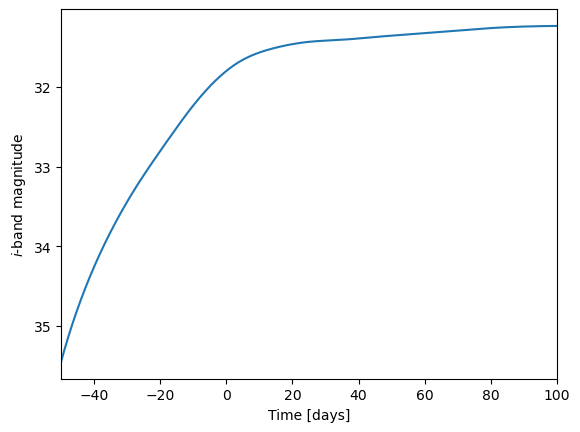

In [78]:
plt.plot(light_curve["MJD"], light_curve["ps_mag_i"])
# plt.ylim(12, 18)
plt.gca().invert_yaxis()
plt.ylabel(r"$i$-band magnitude")
plt.xlabel("Time [days]")
plt.xlim(-50, 100)

## Get observation properties from OpSim

Generate random points on the sky

In [11]:
N = 10

ra_points = coord.Angle(np.random.uniform(low=0, high=360, size=N) * u.degree)
ra_points = ra_points.wrap_at(180*u.degree)
dec_points = np.arcsin(2 * np.random.uniform(size=N) - 1) / np.pi * 180
dec_points = coord.Angle(dec_points * u.degree)

In [12]:
exposure_data = lsst_science_pipeline.opsim_time_series_images_data(ra_points, dec_points, "baseline_v3.0_10yrs",
                                                                    MJD_min=60000, MJD_max=60300, 
                                                                    print_warning=True)


Reading from database sqlite:///../data/OpSim_database/baseline_v3.0_10yrs.db
Read N = 2086079 observations in 43.41 seconds.
No host file.
Coordinate (-42.62275274912281 deg, 15.73605140756275 deg) is not in the LSST footprint. This entry is skipped.
Coordinate (64.49873263637397 deg, 34.67603238561339 deg) is not in the LSST footprint. This entry is skipped.


## Simulate variable_lens_injection with OpSim

In [79]:
index = 5
bands = ['i']
num_pix = 200
transform_pix2angle = np.array([[0.2, 0], [0, 0.2]])

images = lsst_science_pipeline.opsim_variable_lens_injection(lens_class, bands, num_pix, transform_pix2angle, exposure_data[index])
print(images.keys())
print(len(images['obs_time']), "observations")

['bkg_noise', 'psf_kernel', 'obs_time', 'expo_time', 'zero_point', 'calexp_center', 'band', 'lens', 'injected_lens']
12 observations


(80.0, 120.0)

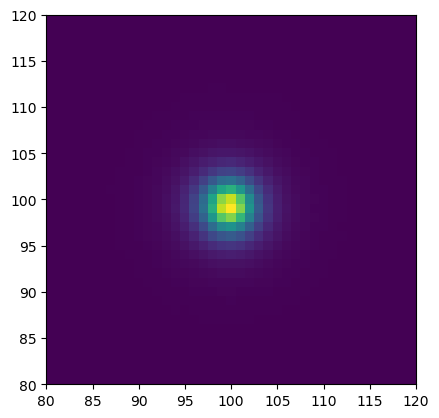

In [80]:
plt.imshow(images["lens"][0], origin="lower")
plt.xlim(80, 120)
plt.ylim(80, 120)

## Simulate lens_image_series with OpSim

In [81]:
im_times = images["obs_time"] - images["obs_time"][0] - 20
repeats = len(im_times)
transform_matrix = np.array([[0.2, 0], [0, 0.2]])
transform_matrix_list = [transform_matrix]
transform_matrix_all = transform_matrix_list * repeats

# Simulate a lens image
images_opsim = lens_image_series(
    lens_class=lens_class,
    band="i",
    mag_zero_point=images["zero_point"],
    num_pix=32,
    psf_kernel=images["psf_kernel"],
    transform_pix2angle=transform_matrix_all,
    exposure_time=images["expo_time"],
    t_obs=im_times,
    with_deflector=True,
    with_source=True,
)

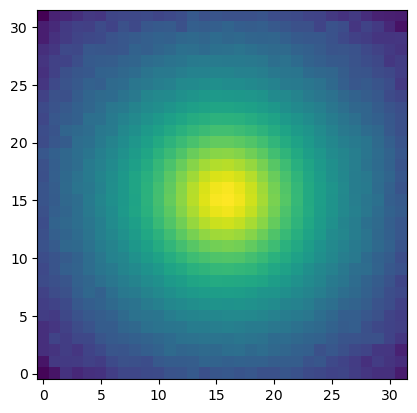

In [82]:
## Images in log scale
log_images = []
for i in range(len(images_opsim)):
    log_images.append(np.log10(images_opsim[i]))

plt.imshow(log_images[0], origin="lower")

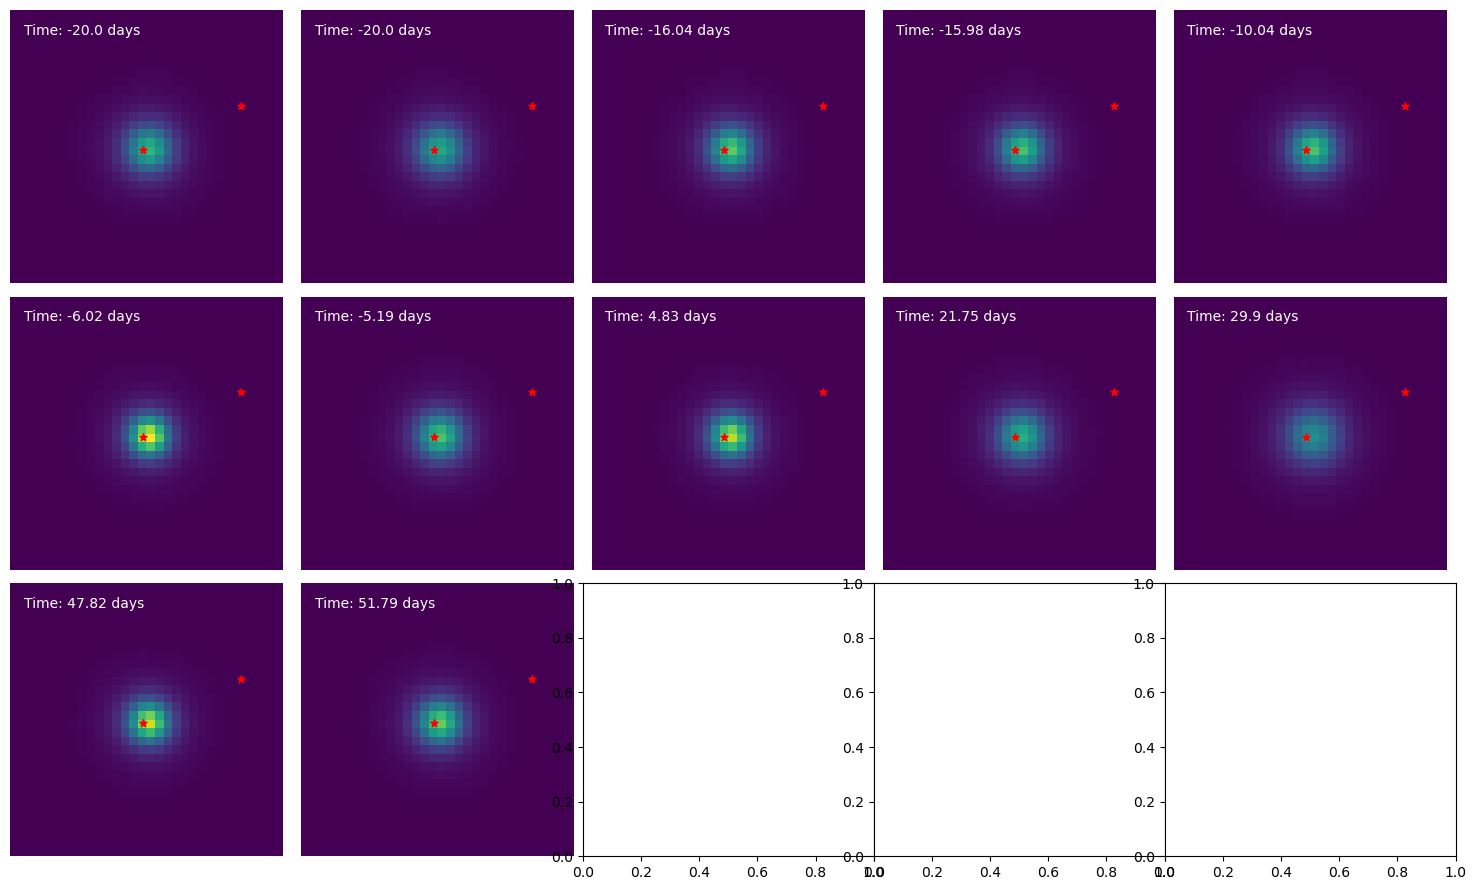

In [83]:
plot_montage = create_image_montage_from_image_list(
    num_rows=3, num_cols=5, images=images_opsim, time=im_times, image_center=pix_coord
)

# add "band=band" and add as text to plots

### Notes

- Can I make a separate function to calculate the zero point? It's a bit messy now within opsim_time_series_images_data.

- calexp_center just contains the object coordinates so is currently a lot of duplicates for each epoch. Maybe there's a more efficient way to save it (or maybe it doesn't matter). 

- 'injected_lens' now contains the same as 'lens', because there is no background image.

### Issues

- if ```catalog_type=None``` instead of ```"scotch"```, the ```double_sersic``` model is not defined. I get the error: ellipticity or semi-major and semi-minor axis are missing for the first light profile in galaxy_list columns.
- Light curve looks a bit strange for a type Ia SN?
- If the light curve goes down to very low magnitudes (~40), then I get a "lam value too large" error (see screenshot).
- Is it possible to give ```LensPop kwargs_variability={"supernovae_lightcurve", "i"}``` a list of bands instead of just one single band? Because otherwise I cannot compute the brightnesses in the other bands so I cannot simulate multiband images.
- ```lens_class._deflector_dict["mag_i"]}```, and ```lens_class._deflector_dict["z"]``` were not working for me, I replaced them with ```lens_class.deflector_magnitude(band='i')``` and ```lens_class.deflector_redshift```.
- Even when I have a lot of potential lens and source galaxies, the resulting strong lenses are very few (order of 10). A more efficient way to sample would be good.
- The magnitudes of the supernovae are all very faint, so in the images I only see the lens galaxy. I tend to sample very low-redshift lenses and high-redshift sources.